### Sprint 1

In [ ]:
!pip install pydicom
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283835 sha256=b6b9cd877affa6309110f353cb9bf5541526a3fd82fa2257f3c0f35dedc2f506
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [ ]:
import os
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pydicom
from pydicom.dataset import Dataset
from pydicom.uid import UID
import datetime
import shutil

def get_image_paths_and_dicom_in_folder(folder_path):
    image_paths = []
    dicom_paths = []

    for filename in os.listdir(folder_path):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            image_paths.append(os.path.join(folder_path, filename))

            # Assuming DICOM files have the same filename as images but with a ".dcm" extension
            dicom_filename = os.path.splitext(filename)[0] + ".dcm"
            dicom_path = os.path.join(folder_path, dicom_filename)
            dicom_paths.append(dicom_path)

    return image_paths, dicom_paths

def select_subset(image_paths, dicom_paths, percentage=50):
    num_images = len(image_paths)
    num_selected = int(percentage / 100 * num_images)
    selected_indices = random.sample(range(num_images), num_selected)
    selected_image_paths = [image_paths[i] for i in selected_indices]
    selected_dicom_paths = [dicom_paths[i] for i in selected_indices]
    return selected_image_paths, selected_dicom_paths

def add_noise(image, noise_level=30):
    row, col, ch = image.shape
    gauss = np.random.normal(0, noise_level, (row, col, ch))
    noisy = image + gauss
    noisy = np.clip(noisy, 0, 255)
    return noisy.astype(np.uint8)

def compute_difference_percentage(original_image, noisy_image):
    mse = np.sum((original_image.astype("float") - noisy_image.astype("float")) ** 2)
    mse /= float(original_image.shape[0] * original_image.shape[1])
    return mse


In [ ]:
import os

# Specify the main folder path
main_folder_path = '/content/drive/MyDrive/dataset/files/'

# Iterate through subfolders
for subfolder_name in os.listdir(main_folder_path):
    subfolder_path = os.path.join(main_folder_path, subfolder_name)

    # Check if the path is a directory
    if os.path.isdir(subfolder_path):
        # Count the number of images in the subfolder
        num_images = len([f for f in os.listdir(subfolder_path) if os.path.isfile(os.path.join(subfolder_path, f))])

        print(f"Folder '{subfolder_name}' has {num_images} images.")


Folder 'cancer' has 182 images.
Folder 'aneurysm' has 168 images.
Folder 'tumor' has 168 images.


In [ ]:
import os
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pydicom
from pydicom.dataset import Dataset
from pydicom.uid import UID
import datetime
import shutil
import tensorflow as tf
from tensorflow import keras
from lime import lime_image
from skimage.segmentation import mark_boundaries


def fast_gradient_sign_method(model, image, label, epsilon=0.01, input_shape=(224, 224, 3)):
    # Resize the image to match the model's input shape
    image = cv2.resize(image, (input_shape[1], input_shape[0]))

    image_tensor = tf.convert_to_tensor(image, dtype=tf.float32)
    image_tensor = tf.expand_dims(image_tensor, axis=0)
    label_tensor = tf.convert_to_tensor(label, dtype=tf.int64)

    with tf.GradientTape() as tape:
        tape.watch(image_tensor)
        prediction = model(image_tensor)
        loss = tf.keras.losses.sparse_categorical_crossentropy(label_tensor, prediction)

    gradient = tape.gradient(loss, image_tensor)
    perturbation = epsilon * tf.sign(gradient)

    adversarial_image = image_tensor + perturbation
    adversarial_image = tf.clip_by_value(adversarial_image, 0, 255)

    return adversarial_image.numpy()[0]

# Modify the input_shape parameter in the load_pretrained_model function
def load_pretrained_model(input_shape=(224, 224, 3)):
    base_model = keras.applications.MobileNetV2(weights='imagenet', input_shape=input_shape, include_top=False)
    base_model.trainable = False

    model = keras.Sequential([
        base_model,
        keras.layers.GlobalAveragePooling2D(),
        keras.layers.Dense(1, activation='sigmoid')  # Adjust this output layer based on your problem
    ])

    # Ensure the model is compiled with an optimizer and loss function
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model



def lime_explanation(model, image, num_samples=1):
    explainer = lime_image.LimeImageExplainer()

    # Lime expects the image to be in [0, 1] range
    normalized_image = image / 255.0

    explanation = explainer.explain_instance(
        normalized_image,
        model.predict,
        top_labels=1,
        num_samples=num_samples
    )

    return explanation

def visualize_explanation(original_image, adversarial_image, explanation):
    # Visualize the explanation on the original image and adversarial image
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    ax1.imshow(original_image)
    ax1.set_title('Original Image')

    temp, mask = explanation.get_image_and_mask(
        explanation.top_labels[0],
        positive_only=True,
        hide_rest=False
    )
    ax2.imshow(mark_boundaries(temp / 2 + 0.5, mask))
    ax2.set_title('Explanation on Adversarial Image')

    plt.show()



9406464/9406464 [==============================] - 1s 0us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 3s 3s/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


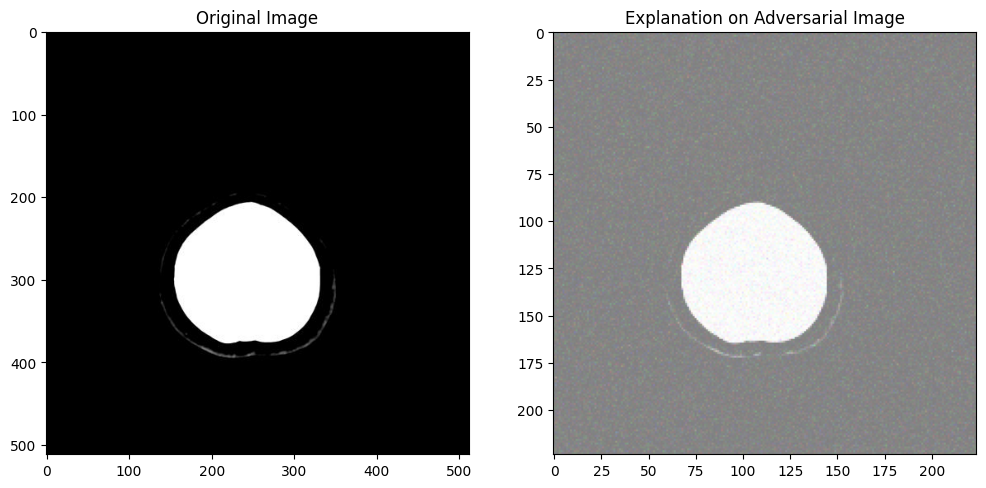

Processed 1 images.


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 121ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


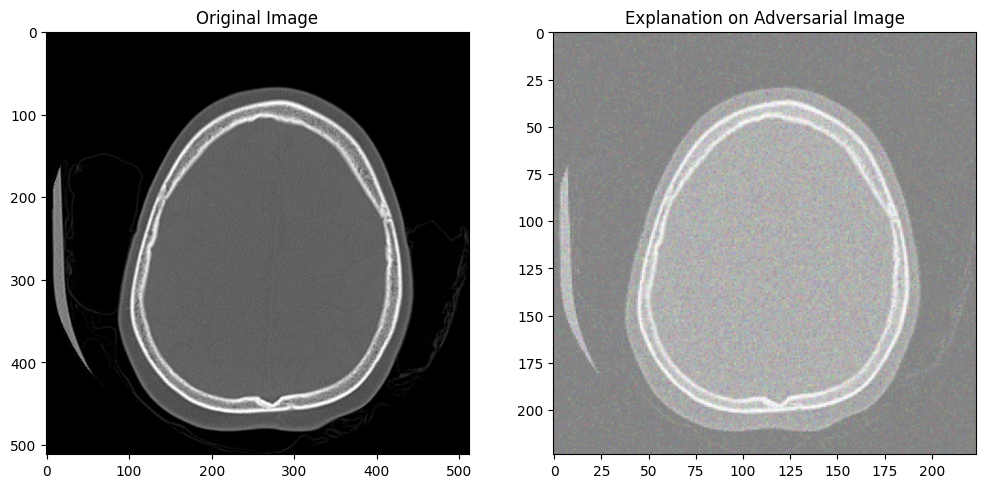

Processed 2 images.


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 111ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


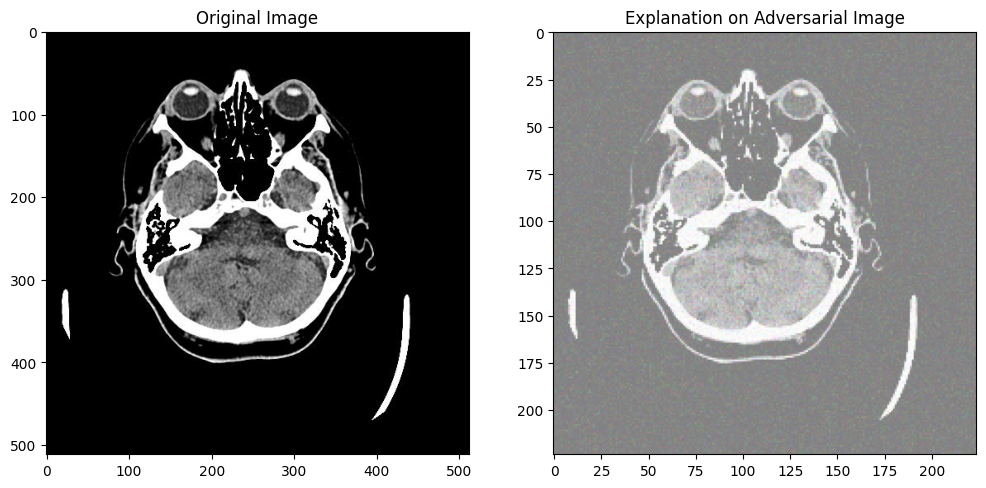

Processed 3 images.


In [ ]:
def process_images_and_dicoms_in_folders(folders, output_folder, noise_level=30, epsilon=0.01, num_lime_samples=1):
    model = load_pretrained_model()
    total_images_processed = 0

    for folder_name in folders:
        folder_path = os.path.join('/content/drive/MyDrive/dataset/files/', folder_name)
        image_paths, dicom_paths = get_image_paths_and_dicom_in_folder(folder_path)
        selected_image_paths, selected_dicom_paths = select_subset(image_paths, dicom_paths)

        for image_path, dicom_path in zip(selected_image_paths[:1], selected_dicom_paths[:1]):
            original_image = cv2.imread(image_path)
            noisy_image = add_noise(original_image, noise_level)

            # Adversarial attack using FGSM
            label = 0
            adversarial_image = fast_gradient_sign_method(model, noisy_image, label, epsilon=epsilon)

            # Save the adversarial image to the output folder
            filename = os.path.basename(image_path)
            output_path = os.path.join(output_folder, f"adversarial_{folder_name}_{filename}")
            cv2.imwrite(output_path, adversarial_image)

            # Lime explanation
            lime_explanation_result = lime_explanation(model, adversarial_image, num_samples=num_lime_samples)

            # Visualize the Lime explanation
            visualize_explanation(original_image, adversarial_image, lime_explanation_result)

            # Copy the corresponding DICOM file to the output folder
            dicom_filename = os.path.basename(dicom_path)
            dicom_output_path = os.path.join(output_folder, f"adversarial_{folder_name}_{dicom_filename}")
            shutil.copy(dicom_path, dicom_output_path)

            total_images_processed += 1
            print(f"Processed {total_images_processed} images.")


folders = ['cancer', 'tumor', 'aneurysm']
output_folder = '/content/drive/MyDrive/dataset/advers_image/'

# Create the output folder if it doesn't exist
os.makedirs(output_folder, exist_ok=True)

process_images_and_dicoms_in_folders(folders, output_folder)

In [ ]:
import os
import cv2
import shutil

def process_images_and_dicoms_in_folders(folders, output_root_folder, noise_level=30, epsilon=0.01, num_lime_samples=1):
    model = load_pretrained_model()
    total_images_processed = 0

    for folder_name in folders:
        input_folder_path = os.path.join('/content/drive/MyDrive/dataset/ad_files/', folder_name)
        output_folder = os.path.join(output_root_folder, f"adversarial_{folder_name}")

        # Create the output folder if it doesn't exist
        os.makedirs(output_folder, exist_ok=True)

        image_paths, dicom_paths = get_image_paths_and_dicom_in_folder(input_folder_path)

        for image_path, dicom_path in zip(image_paths, dicom_paths):
            original_image = cv2.imread(image_path)
            noisy_image = add_noise(original_image, noise_level)

            # Adversarial attack using FGSM
            label = 0
            adversarial_image = fast_gradient_sign_method(model, noisy_image, label, epsilon=epsilon)

            # Save the adversarial image to the output folder
            filename = os.path.basename(image_path)
            output_path = os.path.join(output_folder, f"adversarial_{filename}")
            cv2.imwrite(output_path, adversarial_image)

            # Lime explanation
            lime_explanation_result = lime_explanation(model, adversarial_image, num_samples=num_lime_samples)

            # Visualize the Lime explanation
            visualize_explanation(original_image, adversarial_image, lime_explanation_result)

            # Copy the corresponding DICOM file to the output folder
            dicom_filename = os.path.basename(dicom_path)
            dicom_output_path = os.path.join(output_folder, f"adversarial_{dicom_filename}")
            shutil.copy(dicom_path, dicom_output_path)

            total_images_processed += 1
            print(f"Processed {total_images_processed} images in {folder_name} folder.")

folders = ['ad_cancer', 'ad_tumor', 'ad_aneurysm']
output_root_folder = '/content/drive/MyDrive/dataset/adversarial_images/'

# Create the output root folder if it doesn't exist
os.makedirs(output_root_folder, exist_ok=True)

process_images_and_dicoms_in_folders(folders, output_root_folder)


/usr/local/lib/python3.10/dist-packages/pydicom/valuerep.py:443: UserWarning: The value length (32) exceeds the maximum length of 16 allowed for VR SH.
  warnings.warn(msg)


Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 166
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 98367921766350657393436512297214
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.826.0.1.3680043.8.2198
(0002, 0013) Implementation Version Name         SH: ''
(0002, 0016) Source Application Entity Title     AE: ''
-------------------------------------------------
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'AXIAL']
(0008, 0016) SOP Class UID                       UI: CT Image Storage
(0008, 0018) SOP Instance UID                    UI: 98367921766350657393436512297214
(0008, 0020) Study Date                          DA: '20190628'
(0008, 0050) Accession Number                

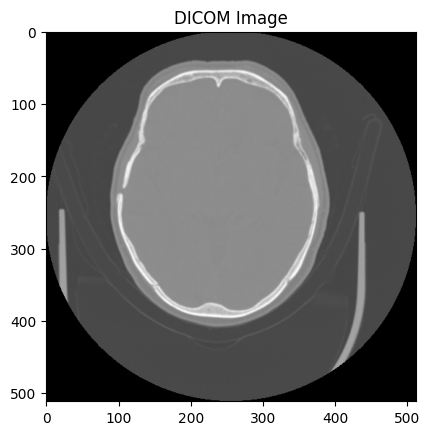

In [ ]:
import pydicom
import matplotlib.pyplot as plt

def read_dicom_file(file_path):
    # Read the DICOM file
    ds = pydicom.dcmread(file_path)

    print(ds)
    pixel_array = ds.pixel_array
    return pixel_array


file_path = '/content/drive/MyDrive/dataset/adversarial_images/adversarial_ad_aneurysm/adversarial_42.dcm'
pixel_array = read_dicom_file(file_path)

# Display the image using matplotlib
plt.imshow(pixel_array, cmap='gray')
plt.title('DICOM Image')
plt.show()


## Training the model with encrypted images

In [ ]:
pip install cryptography


In [ ]:
from cryptography.hazmat.primitives.ciphers import Cipher, algorithms, modes
from cryptography.hazmat.backends import default_backend
import os

def pad(data):
    block_size = algorithms.AES.block_size // 8
    padding_length = block_size - (len(data) % block_size)
    padding = bytes([padding_length]) * padding_length
    return data + padding

def encrypt_image(input_path, output_path, key):
    with open(input_path, 'rb') as file:
        plaintext = file.read()

    plaintext = pad(plaintext)

    cipher = Cipher(algorithms.AES(key), modes.ECB(), backend=default_backend())
    encryptor = cipher.encryptor()

    ciphertext = encryptor.update(plaintext) + encryptor.finalize()

    with open(output_path, 'wb') as file:
        file.write(ciphertext)

def encrypt_images_in_directory(main_folder_path, key):
    for root, dirs, files in os.walk(main_folder_path):
        for file_name in files:
            if file_name.lower().endswith(('.png', '.jpg', '.jpeg', '.gif')):
                input_path = os.path.join(root, file_name)

                # Determine the class folder
                class_folder = os.path.basename(root)

                # Create a folder for encrypted images if it doesn't exist
                encrypted_folder = os.path.join(main_folder_path, 'encrypted_images', class_folder)
                os.makedirs(encrypted_folder, exist_ok=True)

                # Define the output path for the encrypted image
                output_path = os.path.join(encrypted_folder, f"{file_name.split('.')[0]}_encrypted.{file_name.split('.')[-1]}")

                # Encrypt the image and save it to the respective class folder
                encrypt_image(input_path, output_path, key)

# Example Usage
main_folder_path = '/content/drive/MyDrive/dataset/files/'
encryption_key = os.urandom(32)  # 256-bit key for AES-256
print(encryption_key)
encrypt_images_in_directory(main_folder_path, encryption_key)


b'\x1d\x10b\x0f\xfez\xa3\x8e\x9b\xdd\n\x84\xf6\xb8\x9e9*\xe2\x8d\xdc\x1b\xd9\xb6$\xfa\xb1\xac7e\xb0\xc0\xcb'


In [ ]:
from cryptography.hazmat.primitives.ciphers import Cipher, algorithms, modes
from cryptography.hazmat.backends import default_backend
import os

def pad(data):
    block_size = algorithms.AES.block_size // 8
    padding_length = block_size - (len(data) % block_size)
    padding = bytes([padding_length]) * padding_length
    return data + padding

def decrypt_image(input_path, output_path, key):
    with open(input_path, 'rb') as file:
        ciphertext = file.read()

    cipher = Cipher(algorithms.AES(key), modes.ECB(), backend=default_backend())
    decryptor = cipher.decryptor()

    decrypted_data = decryptor.update(ciphertext) + decryptor.finalize()

    # Remove PKCS7 padding
    padding_length = decrypted_data[-1]
    decrypted_data = decrypted_data[:-padding_length]

    with open(output_path, 'wb') as file:
        file.write(decrypted_data)

# Example Usage to Decrypt a Single Image
encrypted_image_path = '/content/drive/MyDrive/dataset/files/encrypted_images/aneurysm/0_encrypted.jpg'
decrypted_output_path = '/content/drive/MyDrive/dataset/files/decrypted_images/aneurysm/0_decrypted.jpg'
encryption_key = b'\x1d\x10b\x0f\xfez\xa3\x8e\x9b\xdd\n\x84\xf6\xb8\x9e9*\xe2\x8d\xdc\x1b\xd9\xb6$\xfa\xb1\xac7e\xb0\xc0\xcb'

# Make sure the output directory exists
os.makedirs(os.path.dirname(decrypted_output_path), exist_ok=True)

decrypt_image(encrypted_image_path, decrypted_output_path, encryption_key)


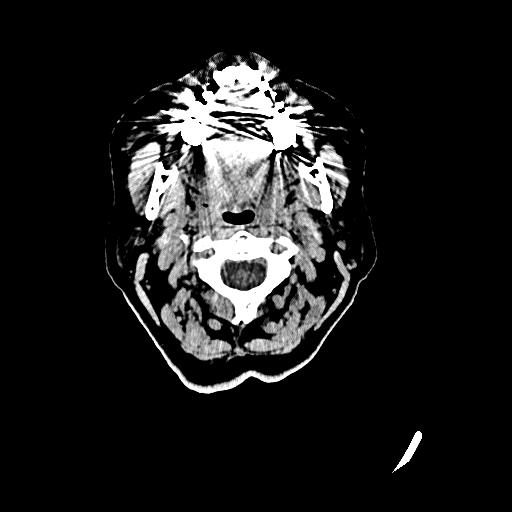

In [ ]:
from IPython.display import Image, display
display(Image(filename='/content/drive/MyDrive/dataset/files/aneurysm/0.jpg'))

In [ ]:
from IPython.display import Image, display
display(Image(filename='/content/drive/MyDrive/dataset/files/encrypted_images/aneurysm/0_encrypted.jpg'))

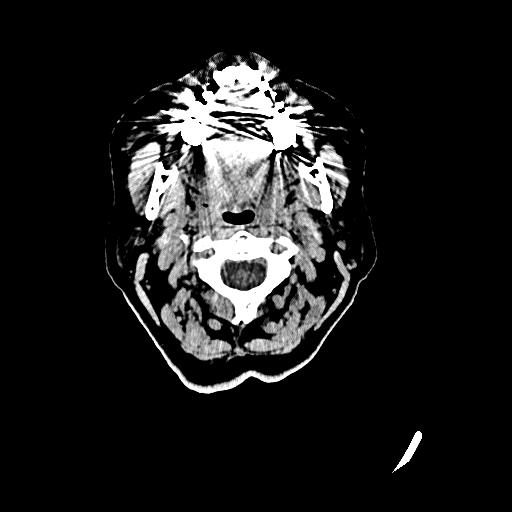

In [ ]:
from IPython.display import Image, display
display(Image(filename='/content/drive/MyDrive/dataset/files/decrypted_images/aneurysm/0_decrypted.jpg'))

In [ ]:
from cryptography.hazmat.primitives.ciphers import Cipher, algorithms, modes
from cryptography.hazmat.backends import default_backend
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def get_ground_truth_label(class_folder):
    # Assuming you have three classes: class1, class2, class3
    if class_folder == 'adversarial_ad_aneurysm':
        return np.array([1, 0, 0])
    elif class_folder == 'adversarial_ad_cancer':
        return np.array([0, 1, 0])
    elif class_folder == 'adversarial_ad_tumor':
        return np.array([0, 0, 1])
    else:
        # Handle the case if the class is not one of the expected classes
        raise ValueError(f"Unknown class: {class_folder}")

def preprocess_image(image_path):
    try:
        img = load_img(image_path, target_size=(224, 224))  # adjust target_size as needed
        img_array = img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array /= 255.0  # normalize pixel values to [0, 1]
        return img_array
    except Exception as e:
        pass


# Example CNN model
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(3, activation='softmax'))  # assuming 3 classes

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Main folder containing class subfolders
main_folder_path = '/content/drive/MyDrive/dataset/adversarial_images/'
encryption_key = b'\x1d\x10b\x0f\xfez\xa3\x8e\x9b\xdd\n\x84\xf6\xb8\x9e9*\xe2\x8d\xdc\x1b\xd9\xb6$\xfa\xb1\xac7e\xb0\xc0\xcb'


# Training loop
for class_folder in os.listdir(main_folder_path):
    class_folder_path = os.path.join(main_folder_path, class_folder)

    for encrypted_image_name in os.listdir(class_folder_path):
        encrypted_image_path = os.path.join(class_folder_path, encrypted_image_name)

        # Preprocess the decrypted image
        try:
            preprocessed_image = preprocess_image(encrypted_image_path)

            label = get_ground_truth_label(class_folder)

            # Train the model on the preprocessed image and label
            model.fit(preprocessed_image, np.expand_dims(label, axis=0), epochs=1)
        except:
          pass

# Save the trained model
model.save('model.h5')

1/1 [==============================] - 0s 13ms/step - loss: 0.0000e+00 - accuracy: 1.0000


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
from cryptography.hazmat.primitives.ciphers import Cipher, algorithms, modes
from cryptography.hazmat.backends import default_backend
import os

# Preprocess the decrypted image
preprocessed_image = preprocess_image("/content/drive/MyDrive/dataset/adversarial_images/adversarial_ad_aneurysm/adversarial_42.jpg")

if preprocessed_image is not None:
    # Make predictions with the model
    predictions = model.predict(preprocessed_image)
    class_labels = ['adversarial_ad_aneurysm', 'adversarial_ad_cancer', 'adversarial_ad_tumor']

    # Get the index with the highest probability
    predicted_class_index = np.argmax(predictions[0])

    # Get the corresponding class label
    predicted_class_label = class_labels[predicted_class_index]

    print("Predicted Class:", predicted_class_label)

    print("Predictions:", predictions)


1/1 [==============================] - 0s 66ms/step
Predicted Class: adversarial_ad_aneurysm
Predictions: [[1.0000000e+00 8.8272539e-17 1.2784878e-15]]


In [ ]:
from cryptography.hazmat.primitives.ciphers import Cipher, algorithms, modes
from cryptography.hazmat.backends import default_backend
import os

def pad(data):
    block_size = algorithms.AES.block_size // 8
    padding_length = block_size - (len(data) % block_size)
    padding = bytes([padding_length]) * padding_length
    return data + padding

def encrypt_image(input_path, output_path, key):
    with open(input_path, 'rb') as file:
        plaintext = file.read()

    plaintext = pad(plaintext)

    cipher = Cipher(algorithms.AES(key), modes.ECB(), backend=default_backend())
    encryptor = cipher.encryptor()

    ciphertext = encryptor.update(plaintext) + encryptor.finalize()

    # Ensure the output directory exists
    os.makedirs(os.path.dirname(output_path), exist_ok=True)

    with open(output_path, 'wb') as file:
        file.write(ciphertext)

# Example Usage for a single test image
input_image_path = '/content/drive/MyDrive/dataset/files/cancer/0.jpg'
output_image_path = '/content/drive/MyDrive/dataset/test_image_encrypted.jpg'
encryption_key = b'\x1d\x10b\x0f\xfez\xa3\x8e\x9b\xdd\n\x84\xf6\xb8\x9e9*\xe2\x8d\xdc\x1b\xd9\xb6$\xfa\xb1\xac7e\xb0\xc0\xcb'

encrypt_image(input_image_path, output_image_path, encryption_key)


In [ ]:
from cryptography.hazmat.primitives.ciphers import Cipher, algorithms, modes
from cryptography.hazmat.backends import default_backend
import os
def preprocess_image(image_path):
    try:
        img = load_img(image_path, target_size=(224, 224))  # adjust target_size as needed
        img_array = img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array /= 255.0  # normalize pixel values to [0, 1]
        return img_array
    except Exception as e:
        pass
# Preprocess the decrypted image
preprocessed_image = preprocess_image('/content/drive/MyDrive/dataset/files/cancer/0.jpg')

if preprocessed_image is not None:
    # Make predictions with the model
    predictions = model.predict(preprocessed_image)
    class_labels = ['adversarial_ad_aneurysm', 'adversarial_ad_cancer', 'adversarial_ad_tumor']

    # Get the index with the highest probability
    predicted_class_index = np.argmax(predictions[0])

    # Get the corresponding class label
    predicted_class_label = class_labels[predicted_class_index]

    print("Predicted Class:", predicted_class_label)


1/1 [==============================] - 0s 33ms/step
Predicted Class: adversarial_ad_aneurysm
